In [1]:
import arviz as az
import numpy as np
import pandas as pd
import pymc as pm
from patsy import dmatrix

import causalpy as cp

## Setting for Mac OS spawning multi-process defaults on M1 chip
sampler_kwargs = {"tune": 2000, "draws": 2000, "target_accept": 0.95, "mp_ctx": "spawn"}

## The Pardox of Propensity Scores in Bayesian Inference

In causal inference the role of the propensity score is often seen to be central. We've seen how the propensity score can be used with the `cp.InversePropensityWeighting` class to correct for a species of selection bias by re-weighting our outcome variable and calculating a causal contrast on the re-weighted scale. Additionally we can use the propensity score to visualise and diagnose problems of overlap or covariate balancing across treatment and control groups. 

These properties give the propensity score a large role to play in _design based_ approaches to causal inference. The focus is on assessing aspects of the treatment allocation to ensure we have identifiability assurances for estimands of interest. 

When we use `cp.InversePropensityWeighting` to apply various re-weighting techniques we perform a two-step  manoeuvre: (1) we estimate the propensity score and (2) apply the inverse-weighting of the score to transform our outcome variable and assess causal contrasts. But being good Bayesians, we might wonder why go to all this trouble? Can we not simple estimate a full-bayesian model of treatment and outcome simultaneously?

In this notebook we'll show why we should be careful attempting to model the joint-distribution of the propensity score and the outcome variable, but still make good use of the propensity score. 

### Brief Digression on the Mathematics

Consider that we have the following three variables:

$$ P(Y, T, X) $$ 

where $Y$ is our outcome variable, $T$ is our treatment variable, and $X$ stands in for all other control variables in scope. Now define the propensity score

$$ e(X) = P(T | X)$$

and our outcome model

$$ P(Y | T, X) = \dfrac{P(Y, T, X)}{P(T, X)}\cdot P(T, X) = \dfrac{P(Y | T, X) \cdot P(T | X) \cdot P(X)}{P(T | X) \cdot P(X)} P(T, X) = \dfrac{P(Y | T, X) \cdot e(X)\cdot P(X)}{e(X) \cdot P(X)} \cdot P(T, X) $$

but now it's clearer to see how the propensity score just cancels out. When we're already conditioning on $X, T$ the information in the propensity score is technically redundant in the Bayesian setting. Add the assumption of unconfoundedness or ignorability used in causal inference. We are arguing that there is no umeasured confounding so conditioning on $X, T$ should be sufficient to identify the causal contrast of interest. 

### Structure of the Presentation

We will first consider a simple simulated data set where we know the true values of the data generating process. We'll first demonstrate how to fit the joint distribution of the propensity score and the outcome in a single joint distribution using `PyMC`. Then we'll show how to fit a two-stage version of the same model. In both models we assume independent priors between the regression for the treatment and the regression for the outcome variable. Nevertheless, we will show that the joint model exhibits a bias due to feedback when there is non-measured confounding i.e. when there is misspecified outcome model. 

- Model Specification
    - Joint Model
    - 2 Stage Model
- Application to Simulated Outcome
- Application to Mosquito Net Data
- Application to Lalonde Data
- Application to NHEFS data.

Note the presentation here owes a debt to the work of Fan Li in {cite:p}`liBayesianProp` and her presentation [here](https://youtu.be/_BjkF2nl7dg?si=Pmza3EoTpz-flT8m&t=26). Additionally we drew on the work and data of Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/18/bayesian-propensity-scores-weights/) and Jordan Nafa and Andrew Heiss [here](https://www.andrewheiss.com/blog/2021/12/20/fully-bayesian-ate-iptw/). 

#### Generate Some Data

In [31]:
N = 4000


def inv_logit(z):
    """Compute the inverse logit (sigmoid) of z."""
    return 1 / (1 + np.exp(-z))


df1 = pd.DataFrame(
    {
        "x1": np.random.normal(0, 1, N),
        "x2": np.random.normal(0, 1, N),
        "x3": np.random.normal(0, 1, N),
    }
)

TREATMENT_EFFECT = 2
df1["trt"] = np.random.binomial(1, inv_logit(df1["x1"] + 6 * df1["x2"] + 7 * df1["x3"]))
df1["outcome"] = (
    1
    + TREATMENT_EFFECT * df1["trt"]
    + df1["x1"]
    + 0.2 * df1["x2"]
    + -3 * df1["x3"]
    + np.random.normal(0, 1, N)
)


df1.head()

,x1,x2,x3,trt,outcome
0,-0.016308,-0.439257,-0.456160,0,1.015246
1,0.727746,-1.099745,1.480021,1,-0.732662
2,0.738903,-0.698852,-1.567861,0,6.228998
3,-0.772407,-1.777497,0.260820,0,0.000351
4,1.641936,1.673974,-0.250408,1,4.654716


### Specifying the Joint Model

Here we will define a model context that fits our data simultaneously for treatment and outcome. We allow that the propensity score estimated in the treatment model is used in a non-parametric spline to flexibly inform the outcome variable

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


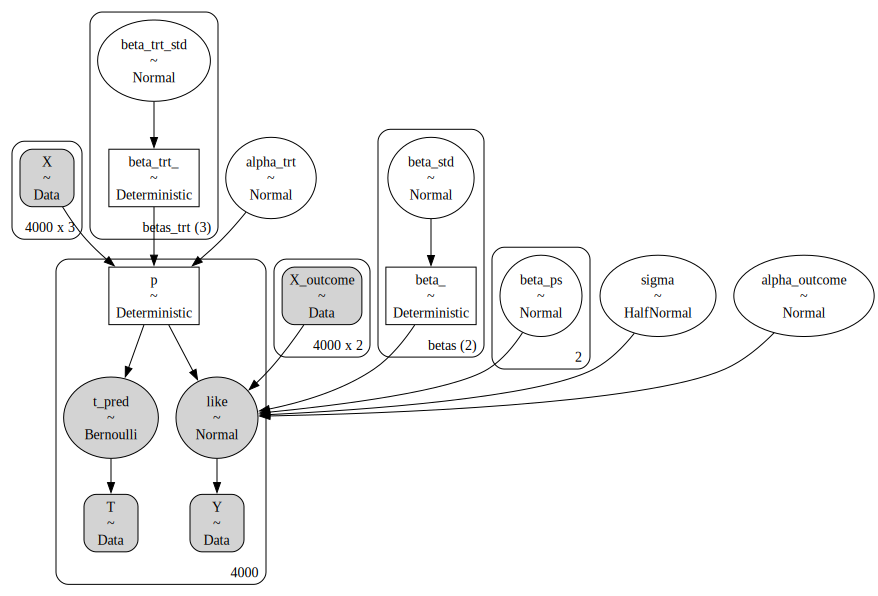

In [32]:
coords = {
    "betas": ["trt", "x1"],
    "betas_trt": ["x1", "x2", "x3"],
    "obs": range(df1.shape[0]),
}

N = df1.shape[0]
X_trt = df1[["x1", "x2", "x3"]].values
X_outcome = df1[["trt", "x1"]].values
T_data = df1["trt"].values
Y_data = df1["outcome"].values


def make_model(
    X_trt,
    X_outcome,
    T_data,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model:
        X_data_trt = pm.Data("X", X_trt)
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        T_data_ = pm.Data("T", T_data, mutable=True)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )
        sigma = pm.HalfNormal("sigma", priors["sigma"])

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model


model = make_model(X_trt, X_outcome, T_data, Y_data, coords)

pm.model_to_graphviz(model)

Note how the two likelihood terms are fit simultaneously. 

### Specifying the 2 Stage Model

Here we allow for a function that takes the same inputs but fits two separate models. First we fit the treatment model then store the `idata_treatment` this xarray object stores the posterior estimates for the propensity score. We pass this through to a second outcome model where we proceed to take a random draw from the posterior and pass it through to the outcome regression via a spline component. This allows us to express any non-linearity in the treatment effect. Additionally it can be seen as a way to augment the outcome model.

While theoretically the propensity score contains no extra information if we are already conditioning on $X$, practically the literature reports that the propensity improves the stability of the causal estimates achievable in Bayesian causal modelling. 

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


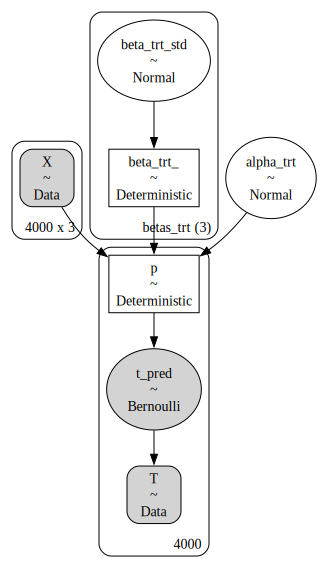

In [33]:
def make_treatment_model(
    X_trt,
    T_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
    },
    noncentred=True,
):
    with pm.Model(coords=coords) as model_trt:
        X_data_trt = pm.Data("X", X_trt)
        T_data_ = pm.Data("T", T_data, mutable=True)

        if noncentred:
            mu_beta_trt, sigma_beta_trt = priors["beta_trt"]
            beta_trt_std = pm.Normal("beta_trt_std", 0, 1, dims="betas_trt")
            beta_trt = pm.Deterministic(
                "beta_trt_",
                mu_beta_trt + sigma_beta_trt * beta_trt_std,
                dims="betas_trt",
            )

        else:
            beta_trt = pm.Normal(
                "beta_trt_",
                priors["beta_trt"][0],
                priors["beta_trt"][1],
                dims="betas_trt",
            )

        alpha_trt = pm.Normal(
            "alpha_trt", priors["alpha_trt"][0], priors["alpha_trt"][1]
        )
        mu_trt = alpha_trt + pm.math.dot(X_data_trt, beta_trt)
        p = pm.Deterministic("p", pm.math.invlogit(mu_trt))

        pm.Bernoulli("t_pred", p=p, observed=T_data_)
    return model_trt


def make_outcome_model(
    X_outcome,
    Y_data,
    coords,
    priors={
        "beta_": [0, 1],
        "beta_trt": [0, 1],
        "alpha_trt": [0, 1],
        "alpha_outcome": [0, 1],
        "sigma": 1,
    },
    noncentred=True,
    spline_component=False,
    propensity_score_idata=None,
):
    propensity_scores = az.extract(propensity_score_idata)["p"]
    with pm.Model(coords=coords) as model_outcome:
        X_data_outcome = pm.Data("X_outcome", X_outcome)
        Y_data_ = pm.Data("Y", Y_data)

        if noncentred:
            mu_beta, sigma_beta = priors["beta_"]
            beta_std = pm.Normal("beta_std", 0, 1, dims="betas")
            beta = pm.Deterministic(
                "beta_", mu_beta + sigma_beta * beta_std, dims="betas"
            )
        else:
            beta = pm.Normal(
                "beta_", priors["beta_"][0], priors["beta_"][1], dims="betas"
            )

        beta_ps = pm.Normal("beta_ps", 0, 1, size=2)

        chosen = np.random.choice(range(propensity_scores.shape[1]))
        p = propensity_scores[:, chosen].values

        alpha_outcome = pm.Normal(
            "alpha_outcome", priors["alpha_outcome"][0], priors["alpha_outcome"][1]
        )
        mu_outcome = (
            alpha_outcome
            + pm.math.dot(X_data_outcome, beta)
            + beta_ps[0] * p
            + beta_ps[1] * (p * T_data)
        )

        if spline_component:
            beta_ps_spline = pm.Normal("beta_ps_spline", 0, 1, size=34)
            B = dmatrix(
                "bs(ps, knots=knots, degree=3, include_intercept=True, lower_bound=0, upper_bound=1) - 1",
                {"ps": p, "knots": np.linspace(0, 1, 30)},
            )
            B_f = np.asarray(B, order="F")
            splines_summed = pm.Deterministic(
                "spline_features", pm.math.dot(B_f, beta_ps_spline.T)
            )
            mu_outcome = mu_outcome + splines_summed

        sigma = pm.HalfNormal("sigma", priors["sigma"])

        _ = pm.Normal("like", mu_outcome, sigma, observed=Y_data_)

    return model_outcome


def make_2step_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, spline_component=False
):
    treatment_model = make_treatment_model(X_trt, T_data, coords, priors)
    with treatment_model:
        idata_treatment = pm.sample_prior_predictive()
        idata_treatment.extend(pm.sample(**sampler_kwargs))

    outcome_model = make_outcome_model(
        X_outcome,
        Y_data,
        coords,
        priors,
        spline_component,
        propensity_score_idata=idata_treatment,
    )
    with outcome_model:
        idata_outcome = pm.sample_prior_predictive()
        idata_outcome.extend(pm.sample(**sampler_kwargs))

    return idata_treatment, idata_outcome, treatment_model, outcome_model


model_treatment = make_treatment_model(X_trt, T_data, coords)

pm.model_to_graphviz(model_treatment)

### Putting it all Together

In [23]:
priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [0, 1],
    "sigma": 1,
}

joint_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with joint_model:
    idata_joint = pm.sample(**sampler_kwargs)

(
    idata_treatment_2s_joint,
    idata_outcome_2s_joint,
    treatment_model_joint,
    outcome_model_joint,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 90 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 16 seconds.
Sampling: [alpha_outcome, beta_, beta_ps, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_, beta_ps, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 20 seconds.


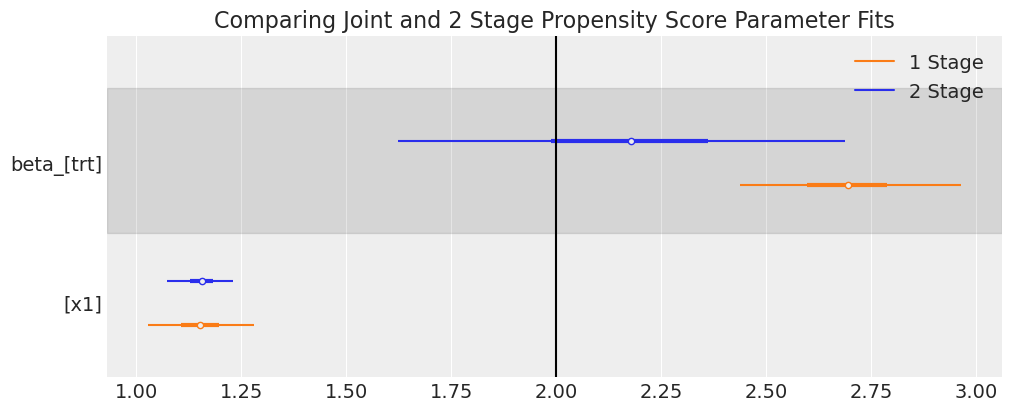

In [24]:
ax = az.plot_forest(
    [idata_outcome_2s_joint, idata_joint],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(2, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [25]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_joint, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_joint, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt       0.014  0.025  -0.031    0.063      0.000   
              beta_[trt]      2.694  0.141   2.438    2.964      0.002   
              beta_[x1]       1.152  0.068   1.027    1.281      0.001   
              beta_ps[0]    -15.480  0.304 -16.069  -14.938      0.005   
              beta_ps[1]     -0.594  0.252  -1.050   -0.104      0.004   
              alpha_outcome   8.598  0.161   8.287    8.896      0.003   
2-stage-model beta_[trt]      2.176  0.282   1.622    2.687      0.004   
              beta_[x1]       1.156  0.041   1.074    1.230      0.001   
              alpha_outcome   3.124  0.064   3.000    3.241      0.001   

                             mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt        0.000    5102.0    5283.0    1.0  
              beta_[trt]       0.002    3902.0    4999.0    1.0  
              beta_[x1]        0.001    4307.0    4850.0    1.0  
              beta_ps[0]       0.004    3222.0    4184.0    1.0  
              beta_ps[1]       0.003    3888.0    4759.0    1.0  
              alpha_outcome    0.002    3413.0    4054.0    1.0  
2-stage-model beta_[trt]       0.003    4386.0    4926.0    1.0  
              beta_[x1]        0.000    6372.0    5671.0    1.0  
              alpha_outcome    0.001    5326.0    5325.0    1.0

Here the models fail to recover substantially similar and correct results. This is interesting and demonstrates a key property of propensity scores in the Bayesian setting. 

### The Problem of Feedback

The issue here is sometimes called Bayesian feedback or "collider bias via the likelihood", and it's a key issue when trying to build joint models for causal inference in the Bayesian paradigm. Because we have fit the outcome and the treatment models simultaneously, and this means that the outcome can influence the posterior distribution of the parameters $\beta$ in the treatment model and it violates the idea of design-before-analysis. We have here an apparent example of a slight bias due to this effect.  The two stage modular approach seems to better recover the treatment effect reported in the literature and avoids the risk of collider bias i.e. in the modular implementation we are able to use the propensity score to adjust for accuracy and compensate for the missing variables `x2` and `x1`. 

<div style="border-left: 4px solid #007acc; padding: 0.5em 1em; background-color: #f0f8ff;">

**💡 Key Take-away:** With an underspecified outcome model, we may use a well specified propensity score for adjusting the model to retrieve accurate treatment effect estimates. However, this tends to breakdown if we have estimated both propensity score and outcome in a joint bayesian model due to feedback effects. The solution is to use the propensity score in a 2 stage fashion. 

</div>

### Causal Estimate with Do-Operator

We can also confirm the model implications through counterfactual imputation. This ties the Bayesian setting back the potential outcomes framework. The fundamental problem of causal inference, when seen as a missing data problem allows us to derive causal estimands through imputation of the potential outcomes. Here we "push forward" the posterior predictive distribution for $Y$ under different treatment settings. 

In [26]:
X_outcome_trt = X_outcome.copy()
X_outcome_trt[:, 0] = 1

X_outcome_ntrt = X_outcome.copy()
X_outcome_ntrt[:, 0] = 0

In [27]:
with pm.do(
    joint_model,
    {"T": np.ones(len(df1), dtype=np.int32), "X_outcome": X_outcome_trt},
    prune_vars=True,
) as treatment_model:
    idata_trt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

with pm.do(
    joint_model,
    {"T": np.zeros(len(df1), dtype=np.int32), "X_outcome": X_outcome_ntrt},
    prune_vars=True,
) as ntreatment_model:
    idata_ntrt = pm.sample_posterior_predictive(idata_joint, var_names=["like", "p"])

Sampling: [like]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling: [like]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [28]:
idata_trt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(3.26519676)

In [29]:
idata_ntrt["posterior_predictive"]["like"].mean()

<xarray.DataArray 'like' ()> Size: 8B
array(0.57154089)

In [30]:
(
    idata_trt["posterior_predictive"]["like"].mean()
    - idata_ntrt["posterior_predictive"]["like"].mean()
)

<xarray.DataArray 'like' ()> Size: 8B
array(2.69365587)

## Nets Example

Next we'll asses a data set used by Andrew Heiss to demonstrate propensity score methods with `brms`. 

In [13]:
nets_df = pd.read_csv("../../../causalpy/data/nets_df.csv")
nets_df["trt"] = nets_df["net_num"]
nets_df["outcome"] = nets_df["malaria_risk"]
nets_df

,id,net,net_num,malaria_risk,income,health,household,eligible,temperature,resistance,trt,outcome
0,1,True,1,33,781,56,2,False,21.1,59,1,33
1,2,False,0,42,974,57,4,False,26.5,73,0,42
2,3,False,0,80,502,15,3,False,25.6,65,0,80
3,4,True,1,34,671,20,5,True,21.3,46,1,34
4,5,False,0,44,728,17,5,False,19.2,54,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...
1747,1748,True,1,18,961,27,4,False,22.1,27,1,18
1748,1749,False,0,49,906,49,5,False,30.7,55,0,49
1749,1750,False,0,17,1325,92,2,False,21.4,52,0,17
1750,1751,False,0,46,879,33,6,False,27.4,62,0,46


In [15]:
coords = {
    "betas": ["trt", "income", "temperature", "health"],
    "betas_trt": ["income", "temperature", "health"],
    "obs": range(nets_df.shape[0]),
}

# Process and Standardise Inputs
N = nets_df.shape[0]
X_trt = nets_df[["income", "temperature", "health"]].values
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = nets_df[["trt", "income", "temperature", "health"]].values
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = nets_df["trt"].values
X_outcome[:, 0] = T_data
Y_data = nets_df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [40, 30],
    "sigma": 10,
}
net_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

with net_model:
    idata_net = pm.sample(tune=2000, target_accept=0.98)

idata_treatment_2s_net, idata_outcome_2s_net, treatment_model_net, outcome_model_net = (
    make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)
)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 13 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


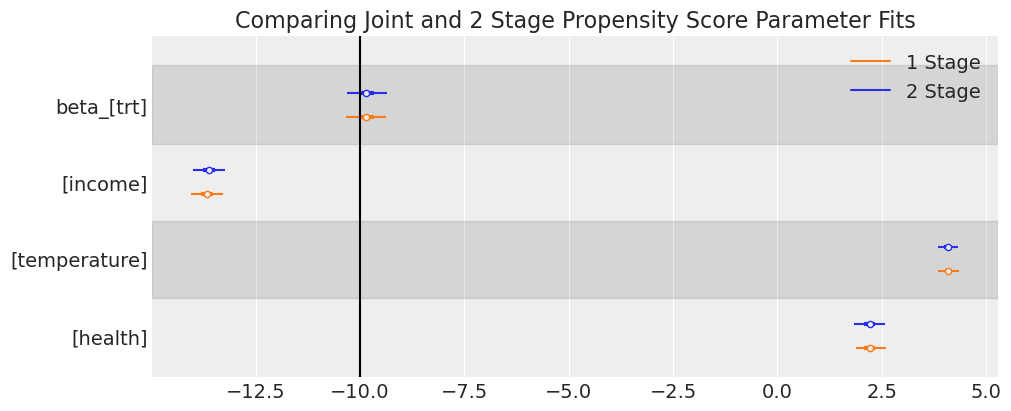

In [21]:
ax = az.plot_forest(
    [idata_outcome_2s_net, idata_net],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(-10, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [22]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_net, var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_net, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt           -0.482  0.052  -0.578   -0.385      0.001   
              beta_[trt]          -9.848  0.256 -10.326   -9.377      0.004   
              beta_[income]      -13.664  0.212 -14.053  -13.269      0.004   
              beta_[temperature]   4.099  0.139   3.837    4.358      0.002   
              beta_[health]        2.207  0.191   1.870    2.594      0.003   
              beta_ps              0.141  1.036  -1.745    2.193      0.024   
              alpha_outcome       39.362  0.432  38.535   40.183      0.010   
2-stage-model beta_[trt]          -9.843  0.257 -10.321   -9.351      0.003   
              beta_[income]      -13.618  0.210 -14.010  -13.228      0.003   
              beta_[temperature]   4.077  0.131   3.838    4.323      0.002   
              beta_[health]        2.212  0.192   1.845    2.569      0.003   
              alpha_outcome       39.527  0.422  38.755   40.319      0.007   

                                  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt             0.001    3920.0    2614.0    1.0  
              beta_[trt]            0.004    4973.0    2829.0    1.0  
              beta_[income]         0.003    2595.0    2645.0    1.0  
              beta_[temperature]    0.002    3181.0    2964.0    1.0  
              beta_[health]         0.003    3133.0    2817.0    1.0  
              beta_ps               0.016    1935.0    2047.0    1.0  
              alpha_outcome         0.007    1758.0    2109.0    1.0  
2-stage-model beta_[trt]            0.003    7987.0    5433.0    1.0  
              beta_[income]         0.002    5038.0    5398.0    1.0  
              beta_[temperature]    0.001    6879.0    5762.0    1.0  
              beta_[health]         0.002    5534.0    5543.0    1.0  
              alpha_outcome         0.005    4161.0    4095.0    1.0

Here again we see broad consistency between both model specifications indicating that the regression adjustment approach in the 2 stage outcome model is appropriate and picks up on all relevant sources of confounding. 

## LaLonde Example

The Lalonde Data set is famous because it highlights a problem with naive causal contrasts. It is discussed by Angrist and Pischke in their _Mostly Harmless Econometrics_ as an example of how regression controls can tolerably address selection effects in a way similar to propensity score weighting. So we should hope the a well specified outcome model can identify the treatment effects plausibly here too. 

In [23]:
lalonde = pd.read_csv("../../../causalpy/data/lalonde.csv")
lalonde[["hispan", "white"]] = pd.get_dummies(lalonde["race"], drop_first=True)
lalonde.dropna(inplace=True)
lalonde.head()

,rownames,treat,age,educ,race,married,nodegree,re74,re75,re78,hispan,white
0,NSW1,1,37,11,black,1,1,0.0,0.0,9930.0460,False,False
1,NSW2,1,22,9,hispan,0,1,0.0,0.0,3595.8940,True,False
2,NSW3,1,30,12,black,0,0,0.0,0.0,24909.4500,False,False
3,NSW4,1,27,11,black,0,1,0.0,0.0,7506.1460,False,False
4,NSW5,1,33,8,black,0,1,0.0,0.0,289.7899,False,False


In [19]:
lalonde.groupby("treat")["re78"].mean().diff()

treat
0           NaN
1   -635.026212
Name: re78, dtype: float64

The Naive group difference suggests a negative effect. 

In [33]:
coords = {
    "betas": ["treat", "age", "educ", "hispan", "white", "married", "nodegree"],
    "betas_trt": ["age", "educ", "hispan", "white", "married", "nodegree"],
    "obs": range(lalonde.shape[0]),
}

N = lalonde.shape[0]
X_trt = (
    lalonde[["age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)

X_outcome = (
    lalonde[["treat", "age", "educ", "hispan", "white", "married", "nodegree"]]
    .astype(np.int32)
    .values
)
T_data = lalonde["treat"].values
Y_data = lalonde["re78"].values


priors = {
    "beta_": [0, 4000],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [2000, 500],
    "sigma": 1000,
}

lalonde_model = make_model(
    X_trt, X_outcome, T_data, Y_data, coords, priors, noncentred=False
)

with lalonde_model:
    idata_lalonde = pm.sample(tune=5000)

(
    idata_treatment_2s_lalonde,
    idata_outcome_2s_lalonde,
    treatment_model_lalonde,
    outcome_model_lalonde,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_, beta_, beta_ps, alpha_trt, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 18 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.


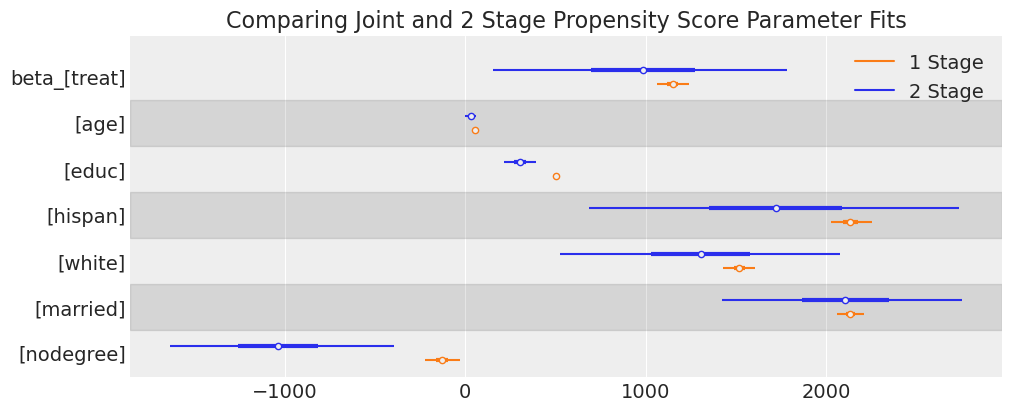

In [26]:
ax = az.plot_forest(
    [idata_outcome_2s_lalonde, idata_lalonde],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

In [32]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_lalonde,
            var_names=["alpha_trt", "beta_", "beta_ps", "alpha_outcome", "sigma"],
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_lalonde, var_names=["beta_", "alpha_outcome", "sigma"]
        ),
    }
)
compare_estimate

mean       sd    hdi_3%   hdi_97%  \
1-stage-model alpha_trt          -1.356    0.134    -1.606    -1.098   
              beta_[treat]     1149.665   47.664  1062.478  1238.637   
              beta_[age]         53.686    1.904    50.176    57.363   
              beta_[educ]       505.357    9.270   488.622   522.969   
              beta_[hispan]    2134.629   60.840  2026.959  2256.010   
              beta_[white]     1518.720   46.575  1431.052  1603.345   
              beta_[married]   2134.526   39.122  2061.917  2207.717   
              beta_[nodegree]  -128.850   50.313  -221.847   -31.139   
              beta_ps             0.029    0.996    -1.874     1.861   
              alpha_outcome   -2002.387  141.365 -2272.877 -1748.521   
              sigma             421.901    0.498   421.013   422.858   
2-stage-model beta_[treat]      982.737  432.534   151.694  1784.738   
              beta_[age]         31.638   15.137     1.777    58.872   
              beta_[educ]       305.380   47.647   214.204   392.922   
              beta_[hispan]    1722.886  548.324   688.310  2736.441   
              beta_[white]     1305.426  415.246   528.163  2075.234   
              beta_[married]   2105.549  356.780  1421.461  2753.465   
              beta_[nodegree] -1036.309  329.961 -1635.165  -394.982   
              alpha_outcome    1487.513  463.684   644.577  2367.598   
              sigma            3884.807   45.999  3797.858  3971.227   

                               mcse_mean  mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt            0.002    0.002    4757.0    3008.0    1.0  
              beta_[treat]         0.745    0.651    4089.0    3363.0    1.0  
              beta_[age]           0.027    0.033    4856.0    2549.0    1.0  
              beta_[educ]          0.170    0.124    2994.0    3271.0    1.0  
              beta_[hispan]        0.976    0.893    3897.0    3167.0    1.0  
              beta_[white]         0.777    0.700    3610.0    2969.0    1.0  
              beta_[married]       0.568    0.595    4742.0    3058.0    1.0  
              beta_[nodegree]      0.881    0.668    3277.0    3122.0    1.0  
              beta_ps              0.012    0.020    6824.0    2648.0    1.0  
              alpha_outcome        2.687    2.095    2776.0    2631.0    1.0  
              sigma                0.006    0.008    6588.0    2729.0    1.0  
2-stage-model beta_[treat]         5.322    4.525    6602.0    5864.0    1.0  
              beta_[age]           0.172    0.161    7782.0    6179.0    1.0  
              beta_[educ]          0.583    0.495    6676.0    6020.0    1.0  
              beta_[hispan]        6.220    5.738    7784.0    5739.0    1.0  
              beta_[white]         5.071    4.386    6708.0    5980.0    1.0  
              beta_[married]       3.982    3.709    8016.0    6347.0    1.0  
              beta_[nodegree]      3.855    3.469    7333.0    6021.0    1.0  
              alpha_outcome        5.358    4.881    7492.0    5674.0    1.0  
              sigma                0.495    0.579    8665.0    5243.0    1.0

Both estimates of the treatment effects accord well with values in the literature. We can be happy that both models are picking up on the structure of the conditional treatment effect well. 

## NHEFS 

Finally we turn to the NHEFS data. This data is known to be have a complex covariate profile for measuring aspects smokers health. We might suspect that there is some unmeasured confounding in this data set that would be hard to pick up on with simple regression controls. 

In [28]:
df = cp.load_data("nhefs")
df[["age", "race", "trt", "smokeintensity", "smokeyrs", "outcome"]].head()

,age,race,trt,smokeintensity,smokeyrs,outcome
0,42,1,0,30,29,-10.093960
1,36,0,0,20,24,2.604970
2,56,1,0,20,26,9.414486
3,68,1,0,3,53,4.990117
4,40,0,0,20,19,4.989251


In [36]:
df["outcome"].std()

np.float64(7.879912854359537)

In [43]:
coords = {
    "betas": [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "betas_trt": [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ],
    "obs": range(df.shape[0]),
}

N = df.shape[0]
X_trt = df[
    [
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_trt = (X_trt - X_trt.mean(axis=0)) / X_trt.std(axis=0)
X_outcome = df[
    [
        "trt",
        "age",
        "smokeintensity",
        "smokeyrs",
        "wt71",
        "active_1",
        "active_2",
        "education_2",
        "education_3",
        "education_4",
        "education_5",
        "exercise_1",
        "exercise_2",
    ]
]
X_outcome = (X_outcome - X_outcome.mean(axis=0)) / X_outcome.std(axis=0)
T_data = df["trt"].values
X_outcome["trt"] = T_data
Y_data = df["outcome"].values

priors = {
    "beta_": [0, 1],
    "beta_trt": [0, 1],
    "alpha_trt": [0, 1],
    "alpha_outcome": [10, 5],
    "sigma": 7,
}

nhefs_model = make_model(X_trt, X_outcome, T_data, Y_data, coords, priors)
with nhefs_model:
    idata_nhefs = pm.sample(**sampler_kwargs)


(
    idata_treatment_2s_nhefs,
    idata_outcome_2s_nhefs,
    treatment_model_nhefs,
    outcome_model_nhefs,
) = make_2step_model(X_trt, X_outcome, T_data, Y_data, coords, priors=priors)

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, beta_std, beta_ps, alpha_trt, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 18 seconds.
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(
Sampling: [alpha_trt, beta_trt_std, t_pred]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_trt_std, alpha_trt]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 12 seconds.
Sampling: [alpha_outcome, beta_ps, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps, alpha_outcome, sigma]


/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.


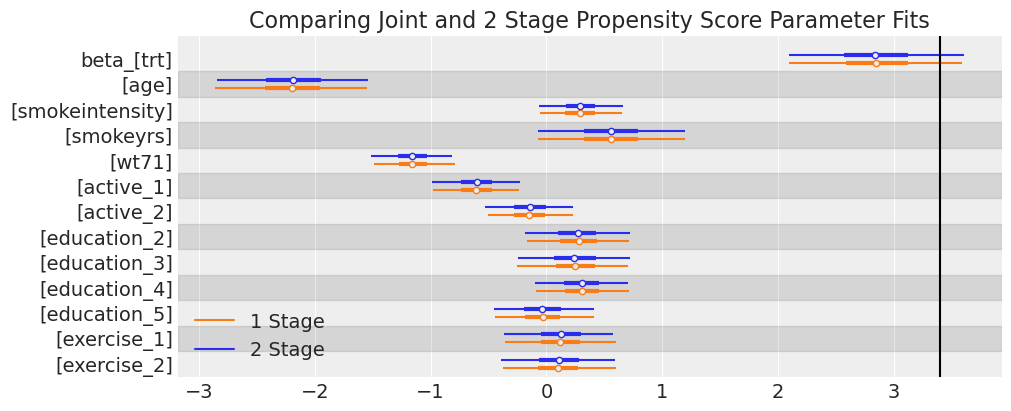

In [44]:
ax = az.plot_forest(
    [idata_outcome_2s_nhefs, idata_nhefs],
    var_names=["beta_"],
    model_names=["2 Stage", "1 Stage"],
    combined=True,
    figsize=(10, 4),
)

ax[0].axvline(3.4, label="True Treatment Value", color="k")
ax[0].set_title("Comparing Joint and 2 Stage Propensity Score Parameter Fits");

Here we see the model specifications start to come apart. 

In [39]:
compare_estimate = pd.concat(
    {
        "1-stage-model": az.summary(
            idata_nhefs, var_names=["alpha_trt", "beta_", "alpha_outcome"]
        ),
        "2-stage-model": az.summary(
            idata_outcome_2s_nhefs, var_names=["beta_", "alpha_outcome"]
        ),
    }
)
compare_estimate

mean     sd  hdi_3%  hdi_97%  mcse_mean  \
1-stage-model alpha_trt             -1.118  0.061  -1.233   -1.004      0.001   
              beta_[trt]             2.939  0.400   2.195    3.684      0.004   
              beta_[age]            -2.232  0.349  -2.884   -1.577      0.005   
              beta_[smokeintensity]  0.318  0.191  -0.042    0.676      0.002   
              beta_[smokeyrs]        0.568  0.345  -0.075    1.215      0.005   
              beta_[wt71]           -1.172  0.185  -1.519   -0.823      0.002   
              beta_[active_1]       -0.604  0.198  -0.982   -0.243      0.002   
              beta_[active_2]       -0.152  0.195  -0.525    0.217      0.002   
              beta_[education_2]     0.282  0.234  -0.161    0.722      0.003   
              beta_[education_3]     0.249  0.249  -0.243    0.680      0.003   
              beta_[education_4]     0.300  0.212  -0.098    0.689      0.003   
              beta_[education_5]    -0.050  0.225  -0.492    0.351      0.003   
              beta_[exercise_1]      0.116  0.251  -0.335    0.616      0.003   
              beta_[exercise_2]      0.099  0.255  -0.367    0.603      0.003   
              alpha_outcome          1.825  0.309   1.252    2.404      0.005   
2-stage-model beta_[trt]             2.839  0.407   2.094    3.609      0.004   
              beta_[age]            -2.195  0.357  -2.869   -1.532      0.005   
              beta_[smokeintensity]  0.300  0.190  -0.038    0.676      0.002   
              beta_[smokeyrs]        0.554  0.349  -0.125    1.210      0.004   
              beta_[wt71]           -1.158  0.187  -1.509   -0.820      0.002   
              beta_[active_1]       -0.601  0.200  -0.975   -0.219      0.002   
              beta_[active_2]       -0.156  0.197  -0.517    0.223      0.002   
              beta_[education_2]     0.292  0.240  -0.166    0.732      0.003   
              beta_[education_3]     0.265  0.257  -0.240    0.728      0.003   
              beta_[education_4]     0.309  0.216  -0.094    0.721      0.003   
              beta_[education_5]    -0.022  0.231  -0.474    0.384      0.003   
              beta_[exercise_1]      0.124  0.254  -0.355    0.590      0.003   
              beta_[exercise_2]      0.101  0.256  -0.365    0.593      0.003   
              alpha_outcome          2.019  0.342   1.372    2.658      0.004   

                                     mcse_sd  ess_bulk  ess_tail  r_hat  
1-stage-model alpha_trt                0.001    8949.0    5466.0    1.0  
              beta_[trt]               0.004    8761.0    5988.0    1.0  
              beta_[age]               0.004    5547.0    6008.0    1.0  
              beta_[smokeintensity]    0.002   10563.0    6292.0    1.0  
              beta_[smokeyrs]          0.003    5670.0    5796.0    1.0  
              beta_[wt71]              0.002    8993.0    6147.0    1.0  
              beta_[active_1]          0.002    7946.0    6574.0    1.0  
              beta_[active_2]          0.002    8523.0    6101.0    1.0  
              beta_[education_2]       0.002    6755.0    6298.0    1.0  
              beta_[education_3]       0.002    5789.0    6192.0    1.0  
              beta_[education_4]       0.002    6595.0    6615.0    1.0  
              beta_[education_5]       0.002    6526.0    6293.0    1.0  
              beta_[exercise_1]        0.002    6283.0    6240.0    1.0  
              beta_[exercise_2]        0.003    6704.0    6212.0    1.0  
              alpha_outcome            0.003    4529.0    5389.0    1.0  
2-stage-model beta_[trt]               0.005   11153.0    5679.0    1.0  
              beta_[age]               0.004    6158.0    5999.0    1.0  
              beta_[smokeintensity]    0.002   11566.0    5889.0    1.0  
              beta_[smokeyrs]          0.004    6058.0    5915.0    1.0  
              beta_[wt71]              0.002   11354.0    6262.0    1.0  
              beta_[active_1]          0.002    9888.

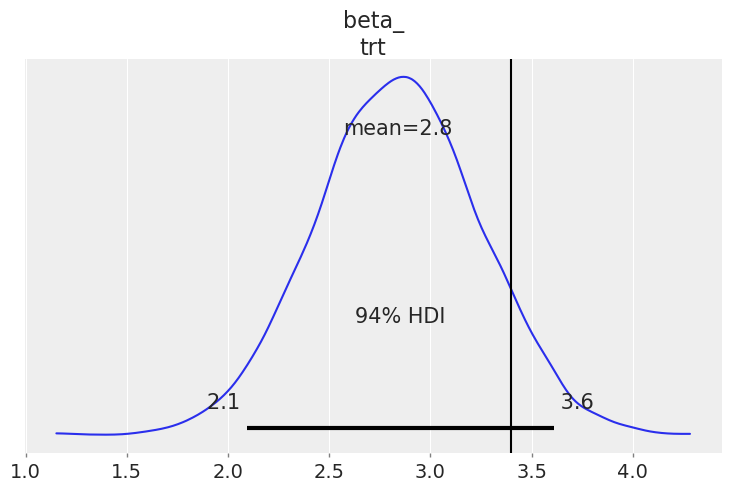

In [42]:
ax = az.plot_posterior(
    idata_outcome_2s_nhefs, var_names=["beta_"], coords={"betas": ["trt"]}
)
ax.axvline(3.4, color="k")

### Two-Stage Outcome Modelling with CausalPy


In [ ]:
formula = """trt ~ 1 + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""

df_standardised = (df - df.mean(axis=0)) / df.std(axis=0)
df_standardised["trt"] = df["trt"]
df_standardised["outcome"] = df["outcome"]
result = cp.InversePropensityWeighting(
    df_standardised,
    formula=formula,
    outcome_variable="outcome",
    weighting_scheme="robust",  ## Will be used by plots after estimation if no other scheme is specified.
    model=cp.pymc_models.PropensityScore(
        sample_kwargs={
            "chains": 4,
            "tune": 2000,
            "draws": 2000,
            "target_accept": 0.95,
            "random_seed": 18,
            "progressbar": False,
            "mp_ctx": "spawn",
        },
    ),
)

result

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 13 seconds.
Sampling: [b, t_pred]
Sampling: [t_pred]


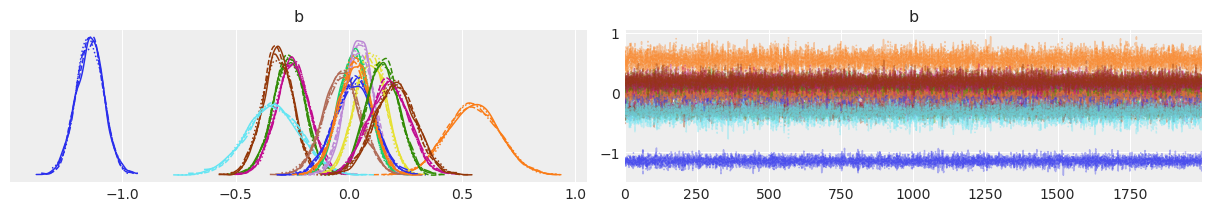

In [ ]:
az.plot_trace(result.idata, var_names=["b"]);

/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


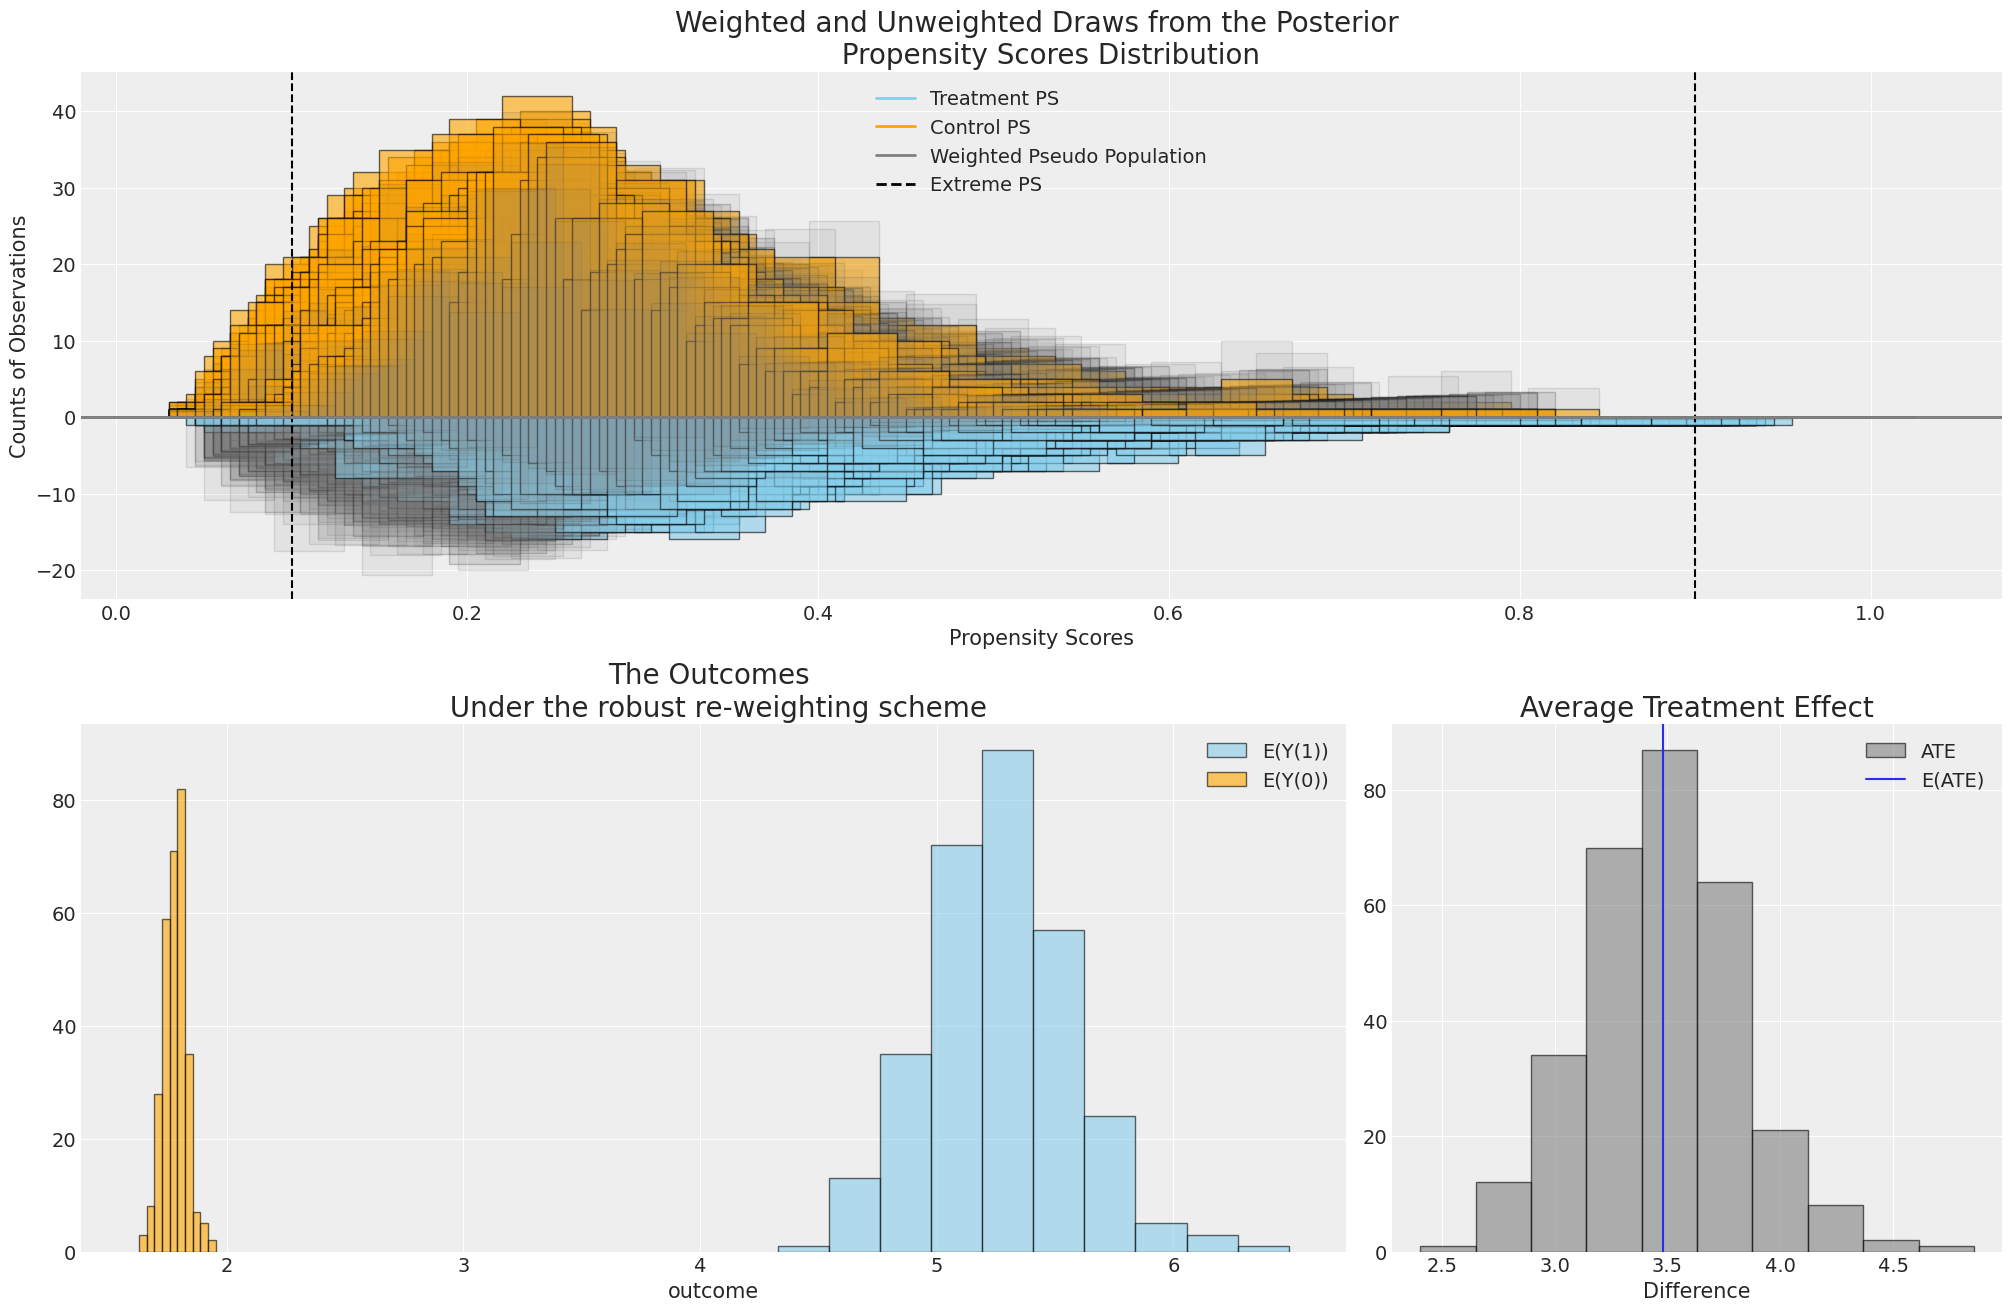

In [ ]:
result.plot_ate(result.idata);

In [ ]:
idata_outcome_cp, model_outcome_cp = result.model.fit_outcome_model(
    result.X_outcome,
    result.y,
    result.coords,
    priors={"b_outcome": [0, 1], "a_outcome": [0, 20], "sigma": 2},
    noncentred=True,
    normal_outcome=True,
)

Sampling: [a_outcome, beta_ps, beta_ps_spline, beta_std, like, sigma]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta_std, beta_ps_spline, beta_ps, a_outcome, sigma]
/Users/nathanielforde/mambaforge/envs/CausalPy/lib/python3.13/site-packages/pymc/step_methods/hmc/quadpotential.py:316: RuntimeWarning: overflow encountered in dot
  return 0.5 * np.dot(x, v_out)
Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 25 seconds.


In [ ]:
az.summary(idata_outcome_cp, var_names=["beta_"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta_[Intercept],-0.005,0.974,-1.860,1.802,0.014,0.010,4793.0,5241.0,1.0
beta_[age],-1.981,0.361,-2.644,-1.297,0.005,0.004,5097.0,5640.0,1.0
beta_[race],0.204,0.231,-0.238,0.629,0.003,0.002,5325.0,6359.0,1.0
beta_[sex],-0.715,0.223,-1.132,-0.293,0.003,0.002,6434.0,5968.0,1.0
beta_[smokeintensity],0.216,0.223,-0.179,0.653,0.003,0.002,5230.0,5667.0,1.0
beta_[smokeyrs],0.253,0.361,-0.454,0.906,0.005,0.004,5185.0,5737.0,1.0
beta_[wt71],-1.445,0.212,-1.848,-1.052,0.003,0.002,7098.0,5961.0,1.0
beta_[active_1],-0.520,0.203,-0.896,-0.141,0.002,0.002,7661.0,6305.0,1.0
beta_[active_2],-0.088,0.204,-0.475,0.291,0.002,0.002,8778.0,6252.0,1.0
beta_[education_2],0.374,0.239,-0.081,0.815,0.003,0.002,4911.0,5889.0,1.0


In [ ]:
from statsmodels.formula import api as smf

formula = """outcome ~ 1 + trt + age + race + sex + smokeintensity + smokeyrs + wt71 + active_1 + active_2 + 
         education_2 + education_3 + education_4 + education_5 + exercise_1 + exercise_2"""


res = smf.ols(formula, df).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                outcome   R-squared:                       0.124
Model:                            OLS   Adj. R-squared:                  0.115
Method:                 Least Squares   F-statistic:                     14.61
Date:                Thu, 10 Jul 2025   Prob (F-statistic):           1.41e-35
Time:                        11:58:05   Log-Likelihood:                -5350.7
No. Observations:                1566   AIC:                         1.073e+04
Df Residuals:                    1550   BIC:                         1.082e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         16.0903      1.508     10.673      0.000      13.133      19.047
trt                3.3812      0.441      7.665      0.000       2.516       4.246
age               -0.2006      0.033     -6.080      0.000      -0.265      -0.136
race               0.6274      0.587      1.069      0.285      -0.524       1.779
sex               -1.4293      0.456     -3.131      0.002      -2.325      -0.534
smokeintensity     0.0207      0.017      1.213      0.225      -0.013       0.054
smokeyrs           0.0516      0.034      1.539      0.124      -0.014       0.117
wt71              -0.0998      0.014     -7.304      0.000      -0.127      -0.073
active_1          -1.1147      0.414     -2.694      0.007      -1.927      -0.303
active_2          -0.4303      0.692     -0.622      0.534      -1.788       0.928
education_2        1.0292      0.612      1.681      0.093      -0.172       2.230
education_3        0.8242      0.561      1.470      0.142      -0.276       1.924
education_4        1.4563      0.841      1.733      0.083      -0.192       3.105
education_5       -0.0405      0.750     -0.054      0.957      -1.511       1.430
exercise_1         0.3839      0.541      0.710      0.478      -0.677       1.445
exercise_2         0.4749      0.564      0.841      0.400      -0.632       1.582
==============================================================================
Omnibus:                      200.616   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1025.738
Skew:                           0.485   Prob(JB):                    1.84e-223
Kurtosis:                       6.844   Cond. No.                         769.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""